In [3]:
%load_ext autoreload
%autoreload 2


import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='svg'
sys.path.insert(0, '../src/TrackingMoCap/Tracking')

from TrackingMoCap.Tracking import label_stationary

# Load Data

In [4]:
trajectories_df = pd.read_csv('../data/raw/trajectories_df-20240514.csv',
                              index_col=0,
                              dtype = {'FlightID': str, 'Bird': str, 'Age': int,
                                       'Category':str,'Iteration':int,'Time':float,
                                       'Frame': int,'X':float,'Y':float,'Z':float})   



## Create a FrameID column

In [5]:
trajectories_df['FrameID'] = trajectories_df['FlightID'] + '_f' + trajectories_df['Frame'].astype(str).str.zfill(3)


## Subset Some Flights

In [6]:
# sub_df = trajectories_df[trajectories_df.Category == 'Pre-wind']
sub_df = trajectories_df[trajectories_df.Category == 'Pre-wind']

sub_df

,FlightID,Bird,Age,Category,Iteration,Marker,Time,Frame,X,Y,Z,BirdID,Brood,Order,Mass_40,Chord_40,FrameID
23520,0201040LN01,purpleR,40,Pre-wind,1,0,0.008333,1,70.326300,1034.77530,1179.2844,201,B,1,17.2,58.5,0201040LN01_f001
23521,0201040LN01,purpleR,40,Pre-wind,1,0,0.016667,2,69.573630,1034.69350,1184.2308,201,B,1,17.2,58.5,0201040LN01_f002
23522,0201040LN01,purpleR,40,Pre-wind,1,0,0.025000,3,69.099205,1034.85620,1188.9563,201,B,1,17.2,58.5,0201040LN01_f003
23523,0201040LN01,purpleR,40,Pre-wind,1,0,0.033333,4,68.577840,1035.16020,1193.6866,201,B,1,17.2,58.5,0201040LN01_f004
23524,0201040LN01,purpleR,40,Pre-wind,1,0,0.041667,5,68.079130,1035.46830,1198.1075,201,B,1,17.2,58.5,0201040LN01_f005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231021,1602040LN24,pinkR-turquoiseL,40,Pre-wind,24,4,3.966667,476,-18.025013,-335.56950,1439.7946,1602,F,2,15.2,60.0,1602040LN24_f476
9231022,1602040LN24,pinkR-turquoiseL,40,Pre-wind,24,4,3.975000,477,-17.708857,-334.03757,1440.6256,1602,F,2,15.2,60.0,1602040LN24_f477
9231023,1602040LN24,pinkR-turquoiseL,40,Pre-wind,24,4,3.983333,478,-17.243382,-332.11694,1442.1188,1602,F,2,15.2,60.0,1602040LN24_f478
9231024,1602040LN24,pinkR-turquoiseL,40,Pre-wind,24,4,3.991667,479,-16.730790,-329.90800,1443.1950,1602,F,2,15.2,60.0,1602040LN24_f479


# Plot an example flight

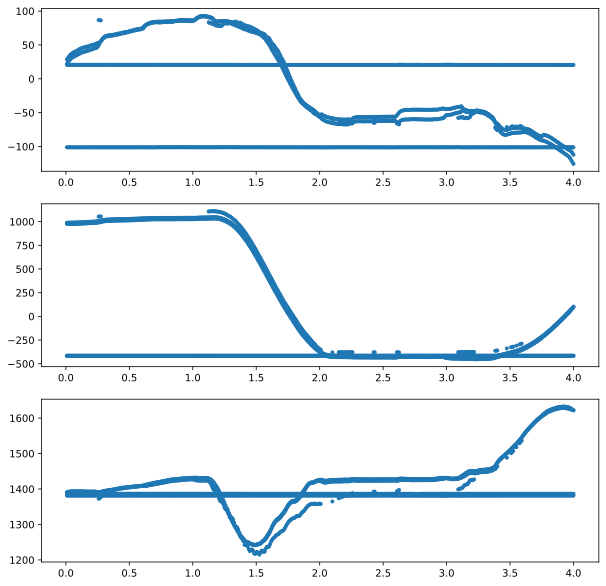

In [7]:
fig, ax = plt.subplots(3,1, figsize=(10,10))



current_sequence = sub_df[sub_df.FlightID == '0601040LN10']
ax[0].plot(current_sequence.Time, current_sequence.X, '.', label='0601040LN10')
ax[1].plot(current_sequence.Time, current_sequence.Y, '.', label='0601040LN10')
ax[2].plot(current_sequence.Time, current_sequence.Z, '.', label='0601040LN10')


plt.show()

In [8]:
print(current_sequence.head())

coords = current_sequence[['X','Y','Z']].values
print(coords.shape)

frames = current_sequence['Frame'].values
print(type(frames))

            FlightID          Bird  Age  Category  Iteration  Marker  \
3464160  0601040LN10  blackR-navyL   40  Pre-wind         10       0   
3464161  0601040LN10  blackR-navyL   40  Pre-wind         10       0   
3464162  0601040LN10  blackR-navyL   40  Pre-wind         10       0   
3464163  0601040LN10  blackR-navyL   40  Pre-wind         10       0   
3464164  0601040LN10  blackR-navyL   40  Pre-wind         10       0   

             Time  Frame          X          Y          Z  BirdID Brood  \
3464160  0.008333      1  20.709948 -417.00928  1386.5704     601     I   
3464161  0.016667      2  20.707302 -417.00900  1386.5759     601     I   
3464162  0.025000      3  20.694717 -417.01900  1386.5719     601     I   
3464163  0.033333      4  20.696653 -417.01935  1386.5773     601     I   
3464164  0.041667      5  20.699976 -417.01373  1386.5815     601     I   

         Order  Mass_40  Chord_40           FrameID  
3464160      1     16.8      61.0  0601040LN10_f001  
3464161 

## Find Stationary Markers in an example trajectory

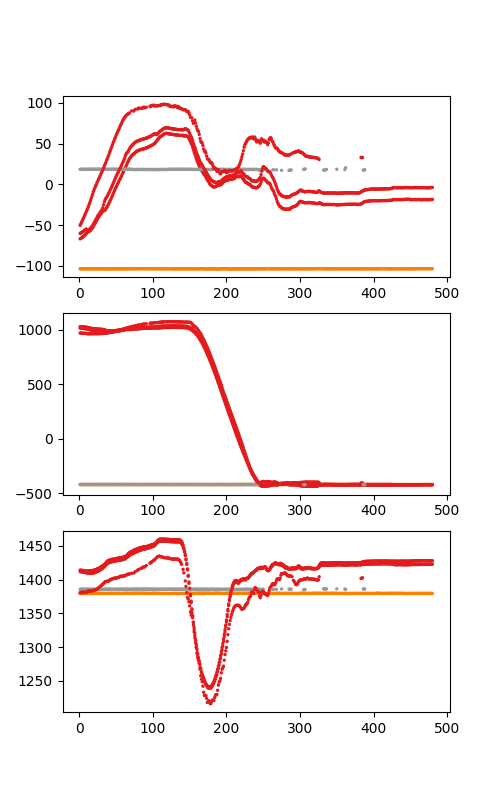

In [340]:

# If you know the stationary points are within a certain area, you can specify the area of interest
# area_of_interest = (x_min, x_max, y_min, y_max, z_min, z_max)

current_sequence = trajectories_df[trajectories_df.FlightID == '0304040WA01'].reset_index()
# current_sequence = trajectories_df[trajectories_df.FlightID == '0601040LN10'].reset_index()

coords = current_sequence[['X','Y','Z']].values
frames = current_sequence['Frame'].values
current_sequence['Stationary'] = 0
# Label stationary points
stationary_labels = label_stationary(coords, frames, 0.1)


fig, ax = plt.subplots(3,1, figsize=(5,8))
ax[0].scatter(current_sequence.Frame, current_sequence.X, s=2, c=stationary_labels, cmap='Set1')
ax[1].scatter(current_sequence.Frame, current_sequence.Y, s=2, c=stationary_labels, cmap='Set1')
ax[2].scatter(current_sequence.Frame, current_sequence.Z, s=2, c=stationary_labels, cmap='Set1')




In [346]:

# This takes about 1.5 mins to run with the full dataframe
def process_group(group):
    coords = group[['X', 'Y', 'Z']].values
    frames = group['Frame'].values
    # area_of_interest = (x_min, x_max, y_min, y_max, z_min, z_max)

    stationary_labels = label_stationary(coords, frames, 0.1)  

    group['Stationary'] = stationary_labels
    return group


# Make sure to reset if running multiple times
trajectories_df['Stationary'] = 0

# Optional: Process only a subset of the dataframe
# quart_ = int(len(trajectories_df)/4)
# processed_df= trajectories_df.iloc[:quart_].groupby('FlightID').apply(process_group, include_groups=False).reset_index(drop=True)

# Process the entire dataframe (1.5 mins)
processed_df= trajectories_df.groupby('FlightID').apply(process_group, include_groups=False).reset_index(drop=True)


print(f"Stationary: {sum(processed_df['Stationary'] != 0)/len(processed_df)}%")
print(f"Moving: {sum(processed_df['Stationary'] == 0)/len(processed_df)}")

0.3773664131823142
0.6226335868176858


## Plot Results by Time

Lots of markers will take a long time to plot

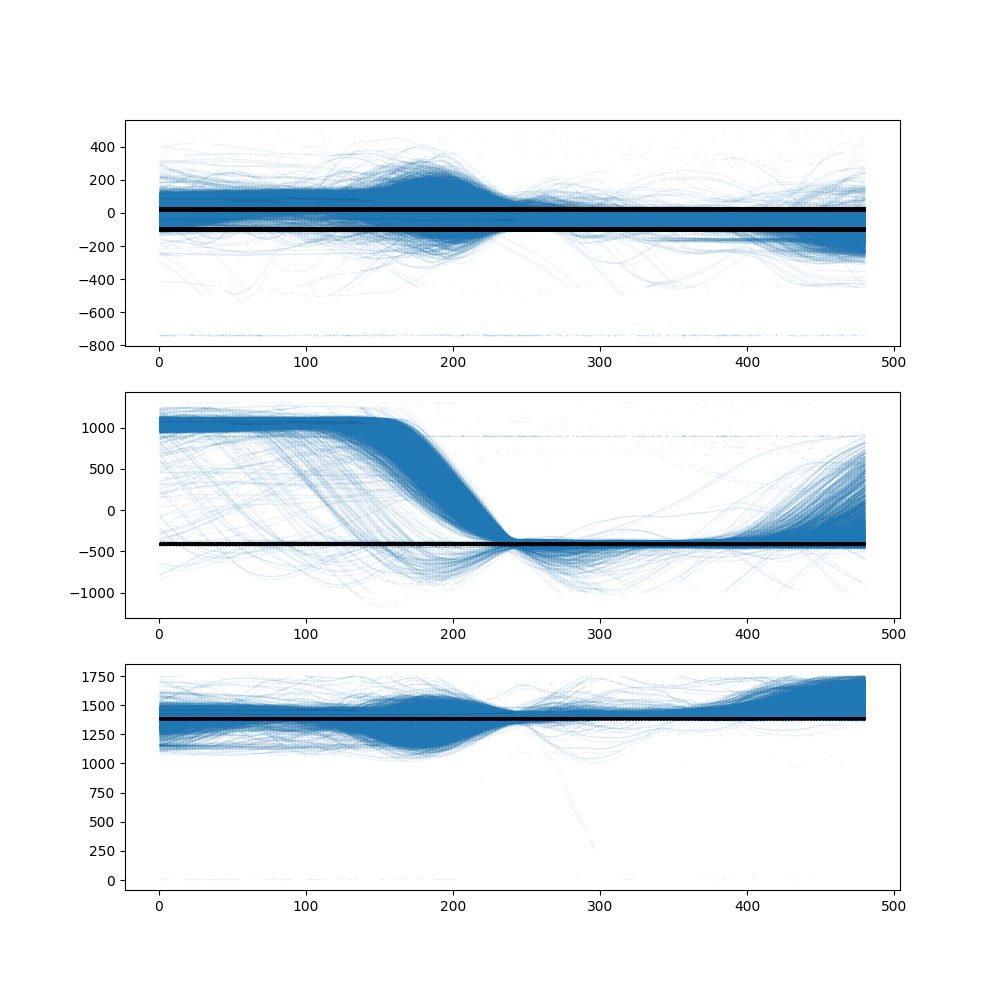

In [342]:
%matplotlib widget

fig, ax = plt.subplots(3,1, figsize=(10,10))

slc = processed_df['Stationary'] == 0
x = processed_df[slc].X
y = processed_df[slc].Y
z = processed_df[slc].Z
time = processed_df[slc].Frame

# Plot the moving points
ax[0].scatter(time, x, s=1, edgecolors='None', alpha=0.1)
ax[1].scatter(time, y, s=1, edgecolors='None', alpha=0.1)
ax[2].scatter(time, z, s=1, edgecolors='None', alpha=0.1)

# Plot the stationary points
slc = processed_df['Stationary'] != 0
x = processed_df[slc].X
y = processed_df[slc].Y
z = processed_df[slc].Z
time = processed_df[slc].Frame

ax[0].scatter(time, x, s=1, c='k', alpha=0.1, edgecolors='None')
ax[1].scatter(time, y, s=1, c='k', alpha=0.1, edgecolors='None')
ax[2].scatter(time, z, s=1, c='k', alpha=0.1, edgecolors='None')


plt.show()

## Plot Markers Around Perch Area

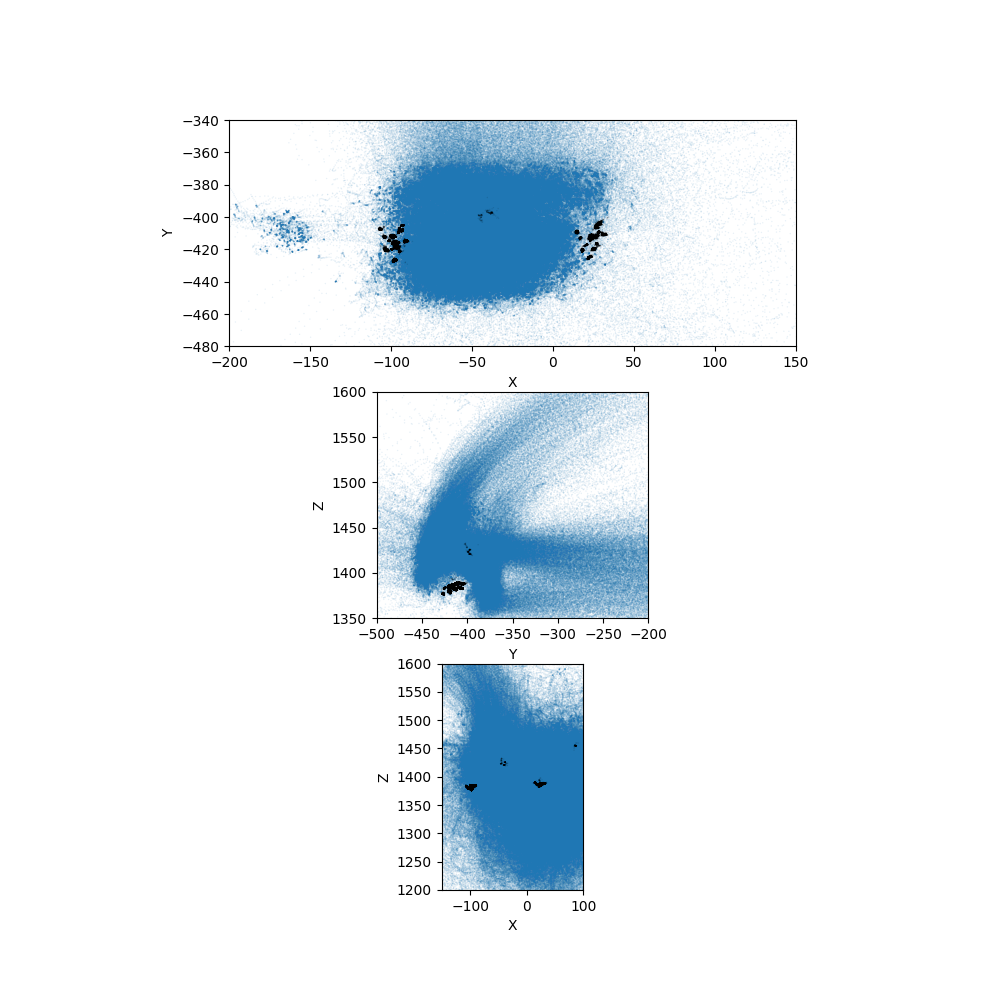

In [347]:
%matplotlib widget

fig, ax = plt.subplots(3,1, figsize=(10,10))

slc = processed_df['Stationary'] == 0
x = processed_df[slc].X
y = processed_df[slc].Y
z = processed_df[slc].Z
time = processed_df[slc].Time

# Plot the moving points
ax[0].scatter(x, y, s=1, edgecolors='None', alpha=0.1)
ax[1].scatter(y, z, s=1, edgecolors='None', alpha=0.1)
ax[2].scatter(x, z, s=1, edgecolors='None', alpha=0.1)

# Plot the stationary points
slc = processed_df['Stationary'] != 0
x = processed_df[slc].X
y = processed_df[slc].Y
z = processed_df[slc].Z
time = processed_df[slc].Time

ax[0].scatter(x, y, s=1, c='k', alpha=0.1, edgecolors='None')
ax[1].scatter(y, z, s=1, c='k', alpha=0.1, edgecolors='None')
ax[2].scatter(x, z, s=1, c='k', alpha=0.1, edgecolors='None')

# Axis labels

ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_aspect('equal')

ax[1].set_xlabel('Y')
ax[1].set_ylabel('Z')
ax[1].set_aspect('equal')

ax[2].set_xlabel('X')
ax[2].set_ylabel('Z')
ax[2].set_aspect('equal')


# Optional: look at the perch points (comment out to see the whole trajectories)
ax[0].set_xlim(-200,150)
ax[0].set_ylim(-480,-340)

ax[1].set_xlim(-500,-200)
ax[1].set_ylim(1350,1600)

ax[2].set_xlim(-150,100)
ax[2].set_ylim(1200,1600)

# x = -96 -100
# y = -418 -414


plt.show()